Dataset Creation
==============================

For this notebook we are going to code up a dataset class that can be used to load the data for the _NifTi_ images and act as a collection
that uses the built-in dunder methods of `__init__`, `__getitem__` and `__len__`.  

I am also going to set it up to allow for caching of the loaded images, if they are going to be referenced multiple times, to allow the operation
to occur more quickly (but this can be disabled).  

In [54]:
import re
import logging
import numpy as np
import nibabel as nib
from torch.utils.data import Dataset, DataLoader


logger = logging.getLogger(__name__)


class NifTiDataset(Dataset):
    """
    Usage: 
      src_path should be path to NifTi images
    """
    def __init__(self, src_path, target_path, layer_count=None, total_layers=None, transformer=None, seed=42):
        self.src_path = src_path
        self.target_path = target_path
        self.transformer = transformer
        self.layer_count = layer_count
        self.total_layers = total_layers
        self.random = np.random.RandomState(seed=seed)
        self._items = None
    
    def __len__(self):
        return len(self.items)
    
    def __getitem__(self, key):
        result = self.load(self.items[key])
        if self.transformer:
            result = self.transformer(result)
        return result
    
    def load(self, item):
        src_file, target_file, layer = item
        logger.debug(f'Loading {src_file}, {target_file} - {layer}')
        src_img = self.load_image(src_file, self.src_path)
        target_img = self.load_image(target_file, self.target_path)
        return (src_img[:,:,layer], target_img[:,:,layer])
            
    @property
    def items(self):
        if self._items is None:
            logger.info('Loading item names from disk')
            src = self.list_items(self.src_path)
            target = self.list_items(self.target_path)
            
            items = [(s, t) for sname, s in src.items() for tname, t in target.items() if sname == tname]
            self._items = []
            for src, target in items:
                total_layers = self.total_layers or self.load_image(src, self.src_path).shape[2]
                if self.layer_count:
                    layer_num_list = list(range(total_layers))
                    self._items.extend([(src, target, i) for i in self.random.choice(layer_num_list, self.layer_count)])
                else:
                    self._items.extend([(src, target, i) for i in range(total_layers)])
                
            self.random.shuffle(self._items)
        
        return self._items
    
    def load_image(self, name, path):
        return nib.load(os.path.join(path, name)).get_fdata()

    def list_items(self, path):
        results = {}
        
        name_regex = r'^(?P<name>.*)\-T[1|2].*$'
        for filename in os.listdir(path):
            matches = re.match(name_regex, filename)
            if matches:
                results[matches['name']] = filename
        
        return results

In [57]:
logging.basicConfig(level=logging.DEBUG)

dataset = NifTiDataset(src_path='../data/hh/t1', target_path='../data/hh/t2', total_layers=180, layer_count=10)
display(len(dataset))
dataset[10]

INFO:__main__:Loading item names from disk


1340

DEBUG:__main__:Loading IXI385-HH-2078-T1_fcm.nii.gz, IXI385-HH-2078-T2_reg_fcm.nii.gz - 121


(array([[-2.57717675e-12, -1.75318098e-06,  1.48324089e-05, ...,
         -9.00389132e-05,  1.46837319e-05, -3.76506847e-07],
        [-1.81544572e-15,  1.51381187e-07, -1.28057457e-06, ...,
         -1.89574735e-06,  3.09085152e-07, -7.92888510e-09],
        [-1.87771111e-15,  2.92958386e-08, -2.47862886e-07, ...,
         -7.10324093e-06,  1.15841829e-06, -2.97028215e-08],
        ...,
        [-1.47858009e-06, -1.51530941e-04,  2.02816256e-04, ...,
          4.09369590e-03,  2.06977664e-03,  4.24279369e-06],
        [ 2.33244123e-07,  1.67987251e-03,  1.89215571e-04, ...,
          3.36630922e-03,  3.07769072e-03,  1.94652421e-05],
        [-5.94273430e-09,  5.41285808e-05,  1.54229639e-07, ...,
          1.85602671e-03,  1.98262418e-03,  2.08427882e-05]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., 

DEBUG:__main__:Loading IXI385-HH-2078-T1_fcm.nii.gz, IXI385-HH-2078-T2_reg_fcm.nii.gz - 121


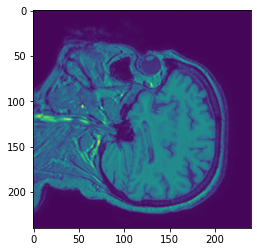

In [60]:
logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt

src, target = dataset[10]

plt.imshow(src)

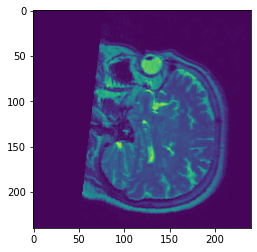

In [61]:
plt.imshow(target)